## FFT TESTBENCH

This notebook takes two inputs (real and imaginary) and gived the real and imaginary parts of the FFT outputs using AXI4. It is then compared with software version of FFT

In [22]:
import sys, os
sys.path.append('/home/xilinx')
os.environ['XILINX_XRT'] = '/usr'
from pynq import Overlay
import numpy as np
from pynq import allocate
from pynq.lib import dma
from scipy.linalg import dft
import matplotlib.pyplot as plt
import time

In [23]:
ol=Overlay('fft.bit')

In [24]:
NUM_SAMPLES = 1024

real_error=np.zeros(NUM_SAMPLES)
imag_error=np.zeros(NUM_SAMPLES)
ind=np.arange(NUM_SAMPLES)
real_rmse=np.zeros(NUM_SAMPLES)
imag_rmse=np.zeros(NUM_SAMPLES)

In [25]:
in_r = allocate(shape=(NUM_SAMPLES,), dtype=np.float32) 
in_i = allocate(shape=(NUM_SAMPLES,), dtype=np.float32)           
out_r = allocate(shape=(NUM_SAMPLES,), dtype=np.float32) 
out_i = allocate(shape=(NUM_SAMPLES,), dtype=np.float32)
a = [i for i in range(NUM_SAMPLES)]
a=np.cos(a)
real=a.real                # Change input real and imaginary value here
img=a.imag
np.copyto(in_r, real)
np.copyto(in_i, img)

In [35]:
fft_ip = ol.fft_0
fft_ip.write(0x10,in_r.physical_address)
fft_ip.write(0x1c,in_i.physical_address)
fft_ip.write(0x28,out_r.physical_address)
fft_ip.write(0x34,out_i.physical_address)
v=time.time()
fft_ip.write(0x00,1)
print(time.time()-v)

0.0007448196411132812


## Verifying Functionality 

In [30]:
c=time.time()
golden_op=np.fft.fft(a)
print(time.time()-c)
for i in range(NUM_SAMPLES):
    real_error[i]="{0:.6f}".format(abs(out_r[i]-golden_op.real[i]))
    imag_error[i]="{0:.6f}".format(abs(out_i[i]-golden_op.imag[i]))

0.019447803497314453


In [31]:
sum_sq_real=0
sum_sq_imag=0
for i in range(NUM_SAMPLES):
    sum_sq_real =sum_sq_real+(real_error[i]*real_error[i])
    real_rmse = np.sqrtSS(sum_sq_real / (i+1))
    sum_sq_imag =sum_sq_imag+(imag_error[i]*imag_error[i])
    imag_rmse = np.sqrt(sum_sq_imag / (i+1))
print("Real Part RMSE: ", real_rmse, "Imaginary Part RMSE:", imag_rmse)    
if real_rmse<0.001 and imag_rmse<0.001:
    print("PASS")
else:
    print("FAIL")

Real Part RMSE:  1.7840247029189356e-05 Imaginary Part RMSE: 1.3904950782005702e-05
PASS


## Displaying Error and Output

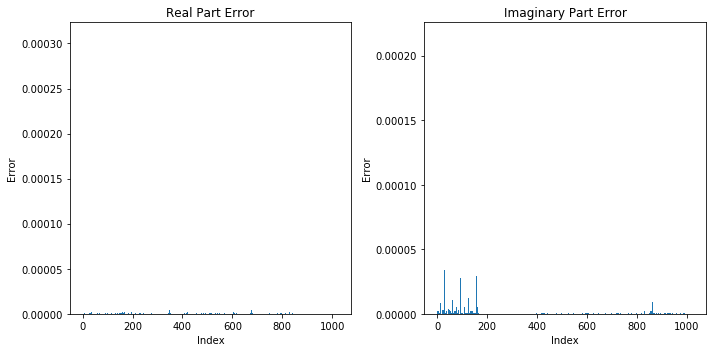

In [34]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.bar(ind,real_error)
plt.title("Real Part Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar(ind,imag_error)
plt.title("Imaginary Part Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

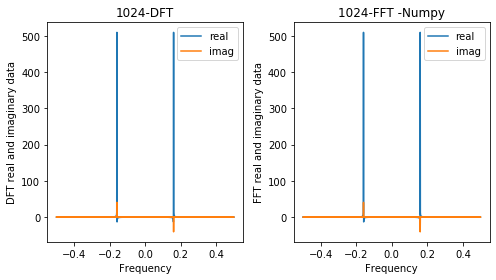

In [33]:
freq=np.fft.fftfreq(1024)

plt.figure(figsize=(7, 4))
plt.subplot(1,2,1)
plt.plot(freq,out_r,label='real')
plt.plot(freq,out_i,label='imag')
plt.title("1024-DFT")
plt.xlabel("Frequency")
plt.ylabel("DFT real and imaginary data")
plt.legend()
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(freq,golden_op.real,label='real')
plt.plot(freq,golden_op.imag,label='imag')
plt.title("1024-FFT -Numpy")
plt.xlabel("Frequency")
plt.ylabel("FFT real and imaginary data")
plt.legend()
plt.tight_layout()
plt.show()